## Contexto
Imagine um cenário que você receba diferentes fotos da mesma pessoa e precise dizer se elas tem o mesmo Plano de Fundo.

Sabemos que essas imagens são diferentes ângulos e feições daquele indivíduo, mas precisamos validar se foram tiradas no mesmo ambiente.

## Objetivos
* Construa um Classificador que consiga dizer quando as imagens tem ou não o mesmo Plano de fundo.
* Utilize o mínimo dos recursos de Package
  * Suponha que queremos manter o ambiente de Deployment tão leve quanto possível 

In [1]:
import io
import dill as pickle
import numpy as np
import pandas as pd
from PIL import Image
from os import listdir
from base64 import b64decode
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, jaccard_score, \
    f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt 
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.pipeline import Pipeline

## Coletando Dados

Para evitar quaisquer implicações com a LGPD estarei utilizando as minhas próprias fotos.

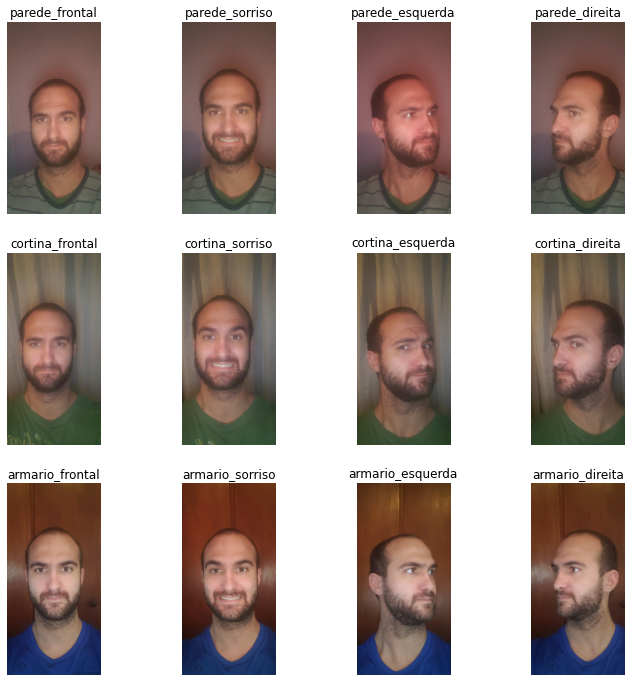

In [2]:
fundos = 'parede, cortina, armario'.split(', ')
desafios = 'frontal, sorriso, esquerda, direita'.split(', ')

def read_close_img(f, d):
    filename = f'{f}_{d}.jpg'
    pil_img = Image.open(filename)
    rbg_mat = np.array(pil_img)
    return (f, d, filename[:-4], rbg_mat)

img_mats = np.array([
    read_close_img(f, d)
    for f in fundos
    for d in desafios
])

def show_images(img_infos, nm_cols = 3):
    nm_rows = int(np.ceil( len(img_infos) / nm_cols))
    fig, axs = plt.subplots(
        nm_rows, nm_cols, 
        figsize=(nm_cols * 3, nm_rows * 4)
    )

    for i, img_info in enumerate(img_infos):
        _, _, img_name, img_data = img_info
        ax = axs[i // nm_cols, i % nm_cols]
        ax.imshow(img_data)
        ax.axis('off')
        ax.set_title(img_name)

    plt.show()

show_images(img_mats, nm_cols=4)

Acima temos 12 fotos em 3 tipos diferentes de fundo e 4 Categorias de Feições.

Poderia iniciar a Analise Exploratória mensurando a compressão, nitidez e amplitude de cores da imagem.

No entanto, nesta demonstração temos o Dataset ideal com as mesmas condições de resolução e iluminação; sem *outliers* e sem *missing values*. Por tanto, estarei guardando a EAD para outro exemplo. 

## Feature Engineering  

Pode parecer que a qtd de imgs é insuficiente, contudo ao cruzarmos as fotos duas a duas teremos um total de **66** registros => C(12, 2)

In [3]:
N = len(img_mats)
cols = 'index1, index2, mesmo_fundo, r2_score, jaccard_score'.split(', ')
linears = np.array([ info[3].ravel() for info in img_mats ])
linears_redu = linears // 32

df = pd.DataFrame([
    [
        i, j, 
        int(img_mats[i, 0] == img_mats[j, 0]),
        r2_score(linears[i], linears[j]), 
        jaccard_score(linears_redu[i], linears_redu[j], average='macro')
    ]
    for i in range(N - 1)
    for j in range(i + 1, N)
], columns = cols)

df

,index1,index2,mesmo_fundo,r2_score,jaccard_score
0,0,1,1,0.929640,0.304133
1,0,2,1,0.911144,0.236956
2,0,3,1,0.901121,0.229289
3,0,4,0,0.885623,0.146815
4,0,5,0,0.889635,0.149531
...,...,...,...,...,...
61,8,10,1,0.962779,0.287916
62,8,11,1,0.971900,0.376090
63,9,10,1,0.965300,0.286624
64,9,11,1,0.970225,0.345753


Note que já estou gerando os cruzamentos e calculando o *r2_score* e *jaccard_score*.

Também estou fazendo uma transformação aqui - ao aplicar <code>linears // 32</code> estou reduzindo a Variabilidade das Cores de 256 tonalidades (de RBG) para 8. 

Com isso as cores agora podem ser formadas com 8 gradações de Vermelho, Verde ou Azul.
Dessa forma o número de combinações possíveis cai de assustadores 16.777.216 (256³) para **512** cores.

Em outras palavras, estou simplificando o cenário das Imagens para melhorar a acurácia do Jaccard Score.

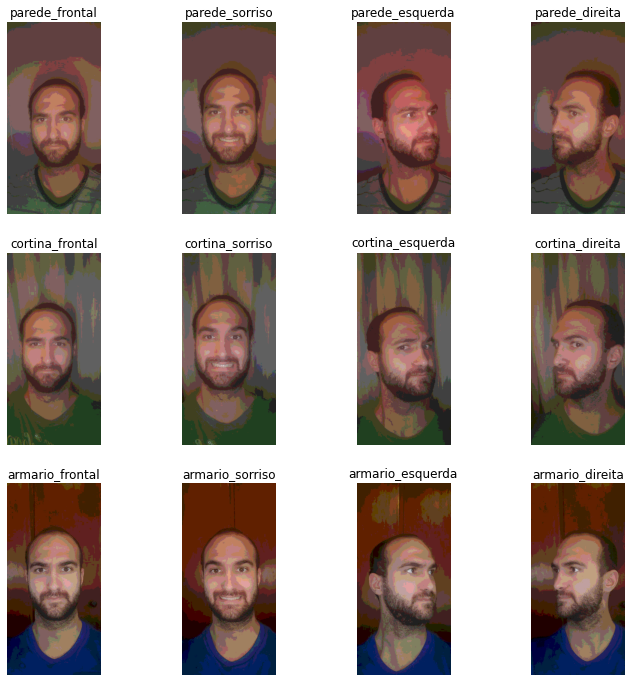

In [4]:
img_infos = img_mats.copy()

for info in img_infos:
    info[3] = (info[3] // 32) * 32

show_images(img_infos, nm_cols = 4)

Acima temos a represetação visual da Redução de Variabilidade das Cores.

Vamos agora avaliar os scores.

## Avaliando Métricas

In [5]:
df.corr()

,index1,index2,mesmo_fundo,r2_score,jaccard_score
index1,1.000000,0.500000,0.303822,0.531218,0.235204
index2,0.500000,1.000000,-0.303822,-0.061898,-0.240793
mesmo_fundo,0.303822,-0.303822,1.000000,0.644095,0.755017
r2_score,0.531218,-0.061898,0.644095,1.000000,0.815505
jaccard_score,0.235204,-0.240793,0.755017,0.815505,1.000000


Conforme vemos acima o **jaccard_score** apresentou uma maior correlação com o nosso indicador de *mesmo_fundo*.

Observe que as variáveis *r2_score* e *jaccard_score* também são altamente correlacionadas entre sí - Devido isso, não é recomendável combinar as duas métricas na nossa Regressão Logística - Caso contrário poderemos cair num caso de **Multicoleniaridade**.

Por tanto, a melhor opção que vejo neste momento é avançarmos apenas com o **jaccard_score**.

In [6]:
X, y = df[['jaccard_score']].to_numpy(), df['mesmo_fundo']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.3, shuffle = True, random_state = 25)

pp_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegressionCV(cv = 8))
])

pp_clf.fit(X_train, y_train)

y_pred = pp_clf.predict(X_test)
y_proba = pp_clf.predict_proba(X_test)

def accuracy_score_(t, p, average):
    return accuracy_score(t, p)
    
print(*[
    f'{fn.__name__:15} = {fn(y, y_pred, average="macro"):.7f}'
    for fn in [
        accuracy_score_, 
        precision_score, 
        recall_score,
        f1_score
    ]
], sep='\n')

accuracy_score_ = 0.9242424
precision_score = 0.9274510
recall_score    = 0.8784722
f1_score        = 0.8989899


Acima estou Padronizando os scores e encontrando o melhor **threshold** para determinar se as imagens são do mesmo fundo.
Também estou usando a Validação **KFold** com K = 8 para melhorar a generalização no Dataset de Teste.

Constate q usando apenas usando o Jaccard_score já temos uma Acurácia superior a 92,4% entre os 66 cruzamentos de Teste (12 fotos).

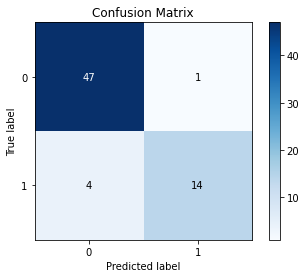

In [7]:
plot_confusion_matrix(y, y_pred)

Através da Matrix de Confusão acima podemos observar:
* Apenas um caso onde o Modelo previu que eram "Mesmo Ambiente" mas as fotos eram de ambientes diferentes.
* 4 casos onde se previu "Ambiente Divergente" em fotos do mesmo ambiente.

Pode-se dizer que o modelo tem uma assertividade maior para informar que as imagens são do mesmo Ambiente 14/15 (93,3%) | 47/51 (92,1%) em "Ambiente Divergentes".

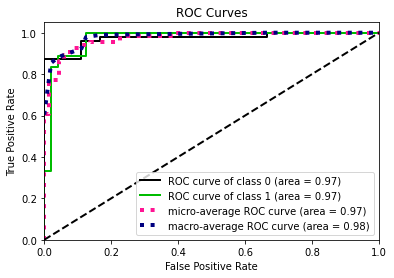

In [8]:
plot_roc(y, y_proba)

Através do Gráfico de Curva ROC também podemos verificar as Probabilidades de Cada Classificaçao.

A Classe 0 "Ambientes Divergentes" e a Classe 1 "Mesmo Ambiente" tiveram área superior de 97% - implica que as as probabalidades estão condizentes com os valores reais - então se o modelo erra, ele o faz prevendo com uma Probabilidade inferior - próxima ao linear dos 50%.

## Conclusão

Usando o Classificador acima e definindo uma das imagens como Baseline já conseguimos dizer se as fotos tem ou não o mesmo Plano de Fundo.

Caso quisermos ser mais conservadores, também podemos mudar o threshold do Classificador que atualmente é de 0.5.
Por exemplo, aumentando threshold para 0.6 poderiamos eliminar os falsos positivos das detecções.
De forma similar, diminuindo o mesmo para 0.4 devemos reduzir drasticamente o número de falsos negativos.

A Decisão sobre qual o melhor linear deve ser tomada de acordo com Problema de Negócio que se propõem a resolver.